**Classification and Regression Trees or CART** for short is a term introduced by Leo Breiman to refer to Decision Tree algorithms that can be used for classification or regression predictive modeling problems.

The representation for the CART model is a binary tree.
The leaf nodes of the tree contain an output variable (y) which is used to make a prediction.

With the binary tree representation of the CART model described above, making predictions is relatively straightforward.

Given a new input, the tree is traversed by evaluating the specific input started at the root node of the tree.

A learned binary tree is actually a partitioning of the input space. You can think of each input variable as a dimension on a p-dimensional space. The decision tree split this up into rectangles (when p=2 input variables) or some kind of hyper-rectangles with more inputs.

New data is filtered through the tree and lands in one of the rectangles and the output value for that rectangle is the prediction made by the model. This gives you some feeling for the type of decisions that a CART model is capable of making, e.g. boxy decision boundaries.

Creating a binary decision tree is actually a process of dividing up the input space. A greedy approach is used to divide the space called recursive binary splitting. This is a numerical procedure where all the values are lined up and different split points are tried and tested using a cost function. The split with the best cost (lowest cost because we minimize cost) is selected. All input variables and all possible split points are evaluated and chosen in a greedy manner (e.g. the very best split point is chosen each time).

In [1]:
import numpy as np

X = np.array(
    [[2.771244718, 1.784783929],
    [1.728571309, 1.169761413],
    [3.678319846, 2.81281357],
    [3.961043357, 2.61995032],
    [2.999208922, 2.209014212],
    [7.497545867, 3.162953546],
    [9.00220326, 3.339047188],
    [7.444542326, 0.476683375],
    [10.12493903, 3.234550982],
    [6.642287351, 3.319983761]]
)

y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

data = np.concatenate((X, np.array([y]).T), axis=1)

In [2]:
data

array([[ 2.77124472,  1.78478393,  0.        ],
       [ 1.72857131,  1.16976141,  0.        ],
       [ 3.67831985,  2.81281357,  0.        ],
       [ 3.96104336,  2.61995032,  0.        ],
       [ 2.99920892,  2.20901421,  0.        ],
       [ 7.49754587,  3.16295355,  1.        ],
       [ 9.00220326,  3.33904719,  1.        ],
       [ 7.44454233,  0.47668338,  1.        ],
       [10.12493903,  3.23455098,  1.        ],
       [ 6.64228735,  3.31998376,  1.        ]])

In [3]:
import matplotlib.pyplot as plt

class1 = np.where(y == 0)[0]
class2 = np.where(y == 1)[0]

plt.scatter(X[class1, 0], X[class1, 1], c='b', label='0', marker='d')
plt.scatter(X[class2, 0], X[class2, 1], c='r', label='1', marker='s')
plt.legend(loc='best')

In [43]:
# Tree
# 0, 1 - листовой узел
# (split_point, left_subtree, right_subtree), where split_point = (attribute_num, attribute_value)


class CartDecisionTree:
            
        
    def partition_by(self, split_point, data):
        """Get subsets from data splitted by split_point"""
        attribute_num, attribute_val = split_point
        left_subset = np.array([d for d in data if d[attribute_num] < attribute_val])
        right_subset = np.array([d for d in data if d[attribute_num] >= attribute_val])
        
        return left_subset, right_subset
    
    
    def find_class_shares(self, split_point, data):
        """Find shares of classes in left and right subsets built upon split_point"""
        left_subset, right_subset = self.partition_by(split_point, data)
        
        left_class_shares = []
        right_class_shares = []
        for c in self.unique_classes:
            left_class_shares.append(
                len([d for d in left_subset if d[-1] == c]) / len(left_subset)
                if len(left_subset) > 0 else np.nan
            )
            right_class_shares.append(
                len([d for d in right_subset if d[-1] == c]) / len(right_subset)
                if len(right_subset) > 0 else np.nan
            )
        
        return left_class_shares, right_class_shares
    
    
    def gini_cost(self, split_point, data):
        """Cost function for classification trees"""
        # Note: Instead of GiniImpurity (=GiniCost, =GiniIndex) we can use weightened GiniGain function
        left_class_shares, right_class_shares = self.find_class_shares(split_point, data)
        return sum(l * (1 - l) + r * (1 - r) for l, r in zip(left_class_shares, right_class_shares))
    
    
    def find_best_split_point(self, data):
        """Find best split point in data"""
        # Note: Instead of attrubutes values for split points we can use adjacent values (better results)
        best_gini = np.inf
        best_split_point = None
        
        for x in data[:, :-1]:
            for attribute_num, attribute_value in enumerate(x):
                split_point = attribute_num, attribute_value
                gini = self.gini_cost(split_point, data)
                
                # Edge case
                if np.isnan(gini): continue
                
                if gini < best_gini:
                    best_split_point = split_point
                    best_gini = gini
        
        assert best_split_point is not None, 'Internal error: best split point is not found'
        
        return best_split_point
    
    
    def build_tree(self, data):
        data_count = len(data)
        classes_counts = [(c, len(np.where(data[:, -1] == c)[0])) for c in self.unique_classes]
        
        for cc in classes_counts:
            if cc[1] == data_count:
                return cc[0]
        
        split_point = self.find_best_split_point(data)
        left_subset, right_subset = self.partition_by(split_point, data)
        left_subtree, right_subtree = self.build_tree(left_subset), self.build_tree(right_subset)
        
        return (split_point, left_subtree, right_subtree)
                
    
    def fit(self, data):
        self.unique_classes = np.unique(data[:, -1])
        self.tree = self.build_tree(data)
    
    
    def predict(self, x, tree=None):
        if tree is None:
            tree = self.tree
        
        if tree in self.unique_classes.tolist():
            return tree
        
        split_point, left_subtree, right_subtree = tree
        attribute_num, attribute_value = split_point

        next_subtree = left_subtree if x[attribute_num] < attribute_value else right_subtree
        
        return self.predict(x, tree=next_subtree)

In [44]:
clf = CartDecisionTree()
clf.fit(data)

In [45]:
clf.tree

((0, 6.642287351), 0.0, 1.0)

In [46]:
y_pred = []

for x in X:
    y_pred.append(clf.predict(x))
    
np.allclose(y_pred, y)

True

In [58]:
# Test

from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [70]:
data = np.concatenate((X_train, np.array([y_train]).T), axis=1)
data[:5]

array([[5.7, 2.9, 4.2, 1.3, 1. ],
       [7.6, 3. , 6.6, 2.1, 2. ],
       [5.6, 3. , 4.5, 1.5, 1. ],
       [5.1, 3.5, 1.4, 0.2, 0. ],
       [7.7, 2.8, 6.7, 2. , 2. ]])

In [71]:
clf = CartDecisionTree()
clf.fit(data)

In [72]:
clf.tree

((3, 1.0),
 0.0,
 ((3, 1.8),
  ((2, 5.6),
   ((1, 2.2),
    1.0,
    ((2, 3.3),
     1.0,
     ((2, 5.1),
      ((0, 7.0),
       ((0, 6.9), ((0, 6.7), ((2, 5.0), ((3, 1.7), 1.0, 2.0), 2.0), 1.0), 1.0),
       1.0),
      1.0))),
   2.0),
  ((1, 2.7),
   2.0,
   ((1, 3.8),
    ((2, 6.7),
     ((2, 6.6),
      ((0, 5.8),
       2.0,
       ((0, 7.7),
        ((2, 6.3),
         ((0, 7.4),
          ((0, 7.2),
           ((2, 6.0),
            ((3, 2.5),
             ((0, 7.1),
              ((1, 3.4),
               ((1, 3.3),
                ((2, 5.7),
                 ((0, 6.9),
                  ((0, 6.8),
                   ((0, 6.7),
                    ((3, 2.4),
                     ((0, 5.9), 2.0, ((3, 2.3), ((1, 3.2), 2.0, 1.0), 2.0)),
                     2.0),
                    2.0),
                   2.0),
                  2.0),
                 2.0),
                2.0),
               2.0),
              2.0),
             2.0),
            2.0),
           2.0),
    

In [74]:
y_pred = []

for x in X_test:
    y_pred.append(clf.predict(x))

In [75]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, y_test)

0.96

In [62]:
from sklearn import tree

sklearn_clf = tree.DecisionTreeClassifier()
sklearn_clf = sklearn_clf.fit(X_train, y_train)

In [79]:
accuracy_score(sklearn_clf.predict(X_test), y_test)

1.0

In [67]:
list(enumerate(iris.feature_names))

[(0, 'sepal length (cm)'),
 (1, 'sepal width (cm)'),
 (2, 'petal length (cm)'),
 (3, 'petal width (cm)')]

In [68]:
list(enumerate(iris.target_names))

[(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]

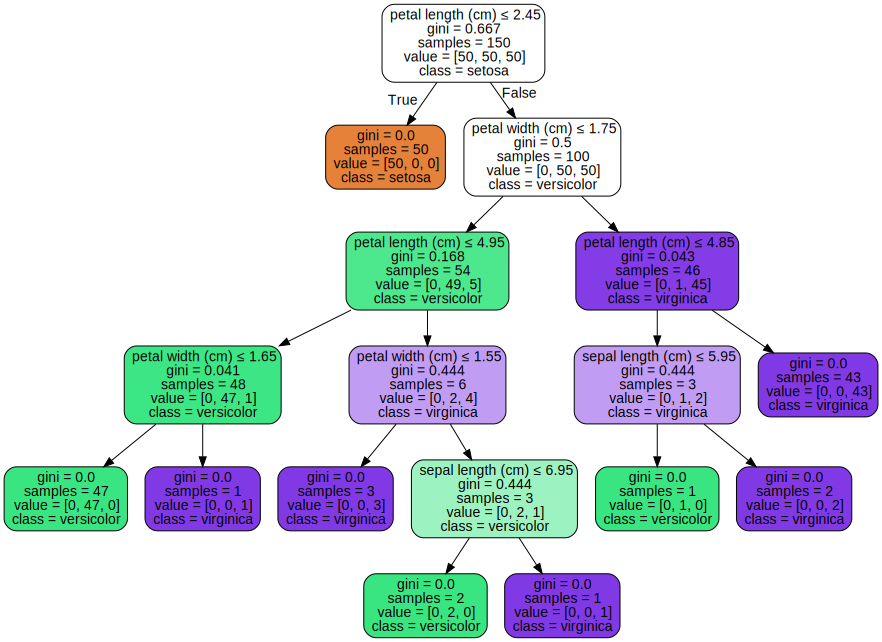

In [63]:
import graphviz

dot_data = tree.export_graphviz(sklearn_clf, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph